In [253]:
import matplotlib
from matplotlib import pyplot
from mpl_toolkits import mplot3d
import numpy as np
from wraparound import wraparound

# For computing eigenvalues
import scipy.sparse.linalg as sla

# For plotting
from matplotlib import pyplot

import scipy.linalg as la

import kwant

In [318]:
sin_30, cos_30 = (1 / 2, np.sqrt(3) / 2)
graphene = kwant.lattice.honeycomb(norbs=2)
a, b = graphene.sublattices

In [329]:
def make_system(L=15, W=5, pot=0.1):
    r = 1

    #### Define the scattering region. ####
    
    # nanoribbon scattering region
    
    sys = kwant.Builder()
    
    def wire(pos):
        x, y = pos
        rr = x**2 + y**2
        return np.abs(x)<L+0.5 and np.abs(y)<W+0.5 #rr**2 < 15 * y * rr + x**2 * y**2
    sys[graphene.shape(wire, (0, 1))] = 0.5
    sys[graphene.neighbors(1)] = 1
    kwant.plot(sys)
    
    #### Define the leads. ####
    
    pv1, pv2 = graphene.prim_vecs
    print (pv1, pv2)
    xsym = kwant.TranslationalSymmetry(-pv1)  # lattice symmetry in -x direction
    ysym = kwant.TranslationalSymmetry(-pv2)  # lattice symmetry in -y direction
    
    def kinetic(site_i, site_j, params):
        return -params['gamma']

    def create_lead_h(W, symmetry, axis=(0, 0)):
        lead = kwant.Builder(symmetry)
        lead[graphene.wire(axis, W)] = 0.
        lead[graphene.neighbors(1)] = kinetic
        return lead
    
    leads = [create_lead_h(W, xsym)]
    leads += [lead.reversed() for lead in leads]  # right lead

    #### Define the leads. ####
    # left lead
    #sym0 = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
    
    #def make_lead_x(W=W, t=1):
    #    syst = kwant.Builder(kwant.TranslationalSymmetry([-1, 0]))
    #    syst[(graphene(0, y) for y in range(W))] = 4 * t
    #    syst[graphene.neighbors()] = -t
    #    return syst

   # def lead0_shape(pos):
    #    x, y = pos
    #    return (np.abs(y)<W)
        #return (-0.4 * r < y < 0.4 * r)

   # sym0 = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
   # lead0 = kwant.Builder(sym0)
   # lead0[graphene.shape(lead0_shape, (-L, 0))] = -0.5
    #lead0[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -1

    # The second lead, going to the top right
   # sym1 = kwant.TranslationalSymmetry(graphene.vec((0, 1)))

   # def lead1_shape(pos):
   #     v = pos[1] * sin_30 - pos[0] * cos_30
    #    return (-0.4 * r < v < 0.4 * r)

    #lead1 = kwant.Builder(sym1)
   # lead1[graphene.shape(lead1_shape, (0, 0))] = 0.5
    #lead1[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -1

    return sys, leads

In [320]:
def compute_evs(sys):
    # Compute some eigenvalues of the closed system
    sparse_mat = sys.hamiltonian_submatrix(sparse=True)

    evs = sla.eigs(sparse_mat, 2)[0]
    print(evs.real)

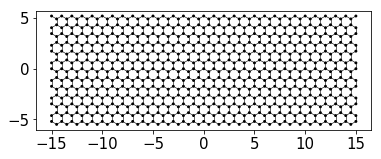

[1. 0.] [0.5       0.8660254]


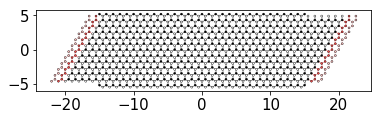

UserCodeError: Error occurred in user-supplied value function "kinetic".
See the upper part of the above backtrace for more information.

In [330]:
pot = 0.1
sys, leads = make_system(pot=pot)
for lead in leads:
    sys.attach_lead(lead)

# To highlight the two sublattices of graphene, we plot one with
# a filled, and the other one with an open circle:
def family_colors(site):
    return 0 if site.family == a else 1

# Plot the closed system without leads.
kwant.plot(sys, site_color=family_colors, site_lw=0.1, colorbar=False)

# Compute some eigenvalues.
compute_evs(sys.finalized())

In [63]:
def plot_conductance(syst, energies): # Compute conductance
    data = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy)
        data.append(smatrix.transmission(1, 0))
    pyplot.figure()
    pyplot.plot(energies, data)
    pyplot.xlabel("energy [t]")
    pyplot.ylabel("conductance [e^2/h]")
    pyplot.show()

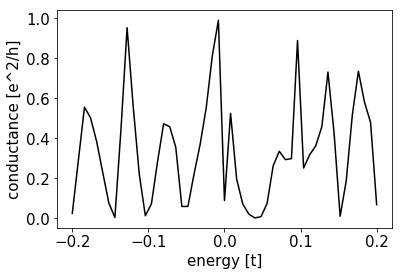

In [64]:
    energies = [-2 * pot + 4. / 50. * pot * i for i in range(51)]
    plot_conductance(sys, energies)

In [65]:
#params = dict(r0=20, delta=10, J=1)
wf = kwant.wave_function(sys, energy=-1)
psi = wf(0)[0]
density = np.abs(psi)**2

In [154]:
ham = sys.hamiltonian_submatrix()
plt.matshow(ham==0, cmap="gray", interpolation=None)
eval, evec = la.eigh(ham)

kwant.plotter.map(sys, abs(evec[:,0])**2);

TypeError: You need a finalized system; use Builder.finalized() first.

In [88]:
wf = kwant.wave_function(sys, energy=-2.0)
psi = wf(0)[0]
rho = kwant.operator.Density(sys)

# calculate the expectation values of the operators with 'psi'
density = rho(psi)
kwant.plotter.density(sys, density)

J_0 = kwant.operator.Current(sys)
current = J_0(psi)
kwant.plotter.current(sys, current)

NameError: name 'evecs' is not defined

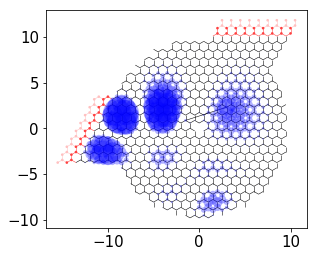

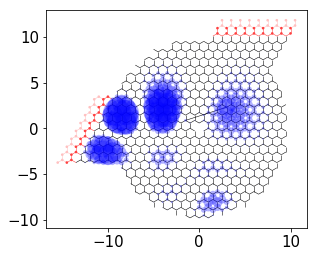

In [93]:
wf = abs(evec[:, 10])**2
def site_size(i):
    return 3 * wf[i] / wf.max()
kwant.plot(sys, site_size=site_size, site_color=(0, 0, 1, 0.3),
            hop_lw=0.1)

Let's construct a hexagonal bilayer lattice

In [313]:
bilayer = kwant.lattice.general([(1,0,0), (sin_30,cos_30,0)],
                                 [(0,0,0), (0,1/np.sqrt(3),0), (0,0,2), (0,1/np.sqrt(3),2)])
a1, b1, a2, b2 = bilayer.sublattices

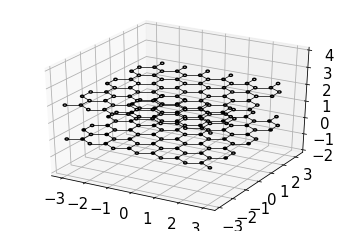

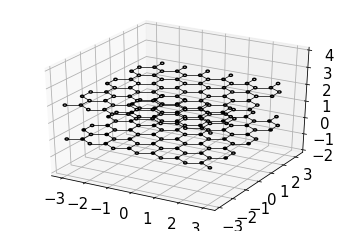

In [314]:
sys = kwant.Builder()
L = 3.5
W = 3.2
    
def ribbon(pos):
    x, y, z = pos
    return np.abs(x)<L and np.abs(y)<W and z<2.2 and z>-1
sys[bilayer.shape(ribbon, (0, 0, 0))] = 0.0

hoppings = (((0, 0), a1, b1), ((0, 1), a1, b1), ((-1, 1), a1, b1),((0, 0), a2, b2), ((0, 1), a2, b2), ((-1, 1), a2, b2))
sys[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -1

def family_colors(site):
    if site.family == a1:
        color=0
    if site.family == a2:
        color=1
    if site.family == b1:
        color=2
    if site.family == b2:
        color=3 
    return color
kwant.plot(sys, site_color=family_colors, site_lw=0.1, site_size=0.1, hop_lw=0.05, colorbar=False)

In [265]:
# Compute some eigenvalues.

def compute_evs(sys):
    # Compute some eigenvalues of the closed system
    sparse_mat = sys.hamiltonian_submatrix(sparse=True)

    evs = sla.eigs(sparse_mat, 4)[0]
    print(evs.real)
    
compute_evs(sys.finalized())



[ 2.90971957 -2.90971957 -2.90971957  2.90971957]


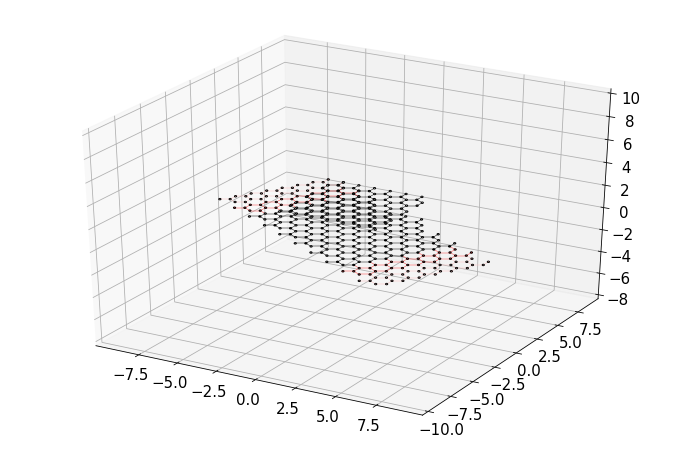

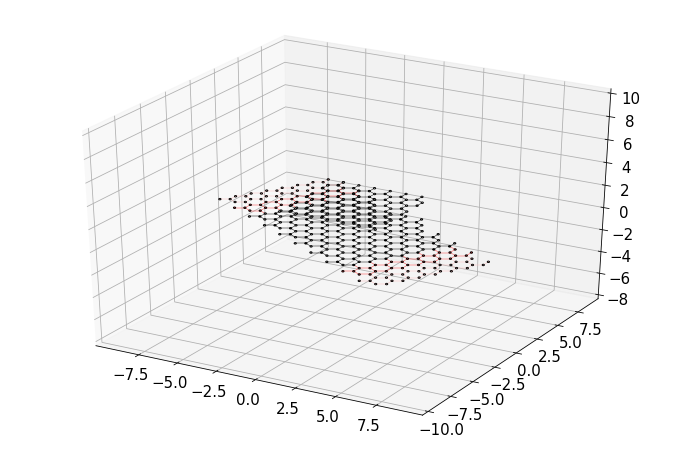

In [315]:
## leads ##

pv1, pv2 = bilayer.prim_vecs
xsym = kwant.TranslationalSymmetry(pv2 - 2*pv1)  # lattice symmetry in -x direction
ysym = kwant.TranslationalSymmetry(-pv2)  # lattice symmetry in -y direction
hoppingslayer1 = (((0, 0), a1, b1), ((0, 1), a1, b1), ((-1, 1), a1, b1))
hoppingslayer2 = (((0, 0), a2, b2), ((0, 1), a2, b2), ((-1, 1), a2, b2))

def lead_shape(pos):
    x, y, z = pos
    return (np.abs(y)<W and np.abs(z)<1)

def create_lead_h1(W, symmetry):
    lead = kwant.Builder(symmetry)
    lead[bilayer.shape(lead_shape, (0, W, 0))] = 0.0
    lead[[kwant.builder.HoppingKind(*hopping) for hopping in hoppingslayer1]] = -1
    return lead
def create_lead_h2(W, symmetry):
    lead = kwant.Builder(symmetry)
    lead[bilayer.shape(lead_shape, (2, 0, 2))] = 0.0
    lead[[kwant.builder.HoppingKind(*hopping) for hopping in hoppingslayer2]] = -1
    return lead

leads = [create_lead_h(W, xsym)]
leads += [create_lead_h2(W, xsym)]
leads += [lead.reversed() for lead in leads]  # right lead

for lead in leads:
    sys.attach_lead(lead)
    
kwant.plot(sys, site_color=family_colors, site_lw=0.1, site_size=0.1, hop_lw=0.05, colorbar=False,  fig_size=(12, 8))

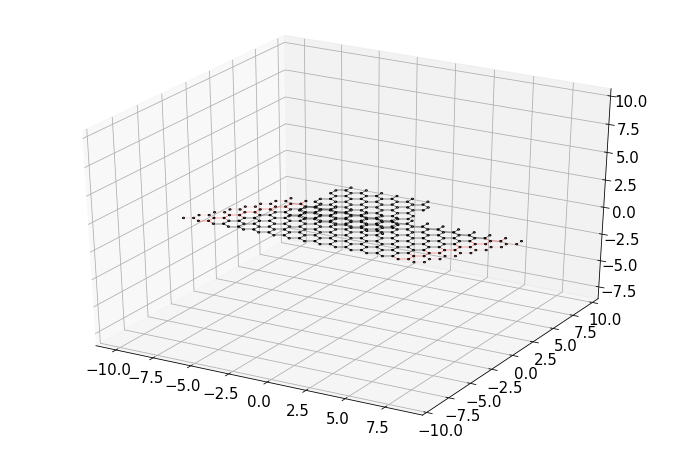

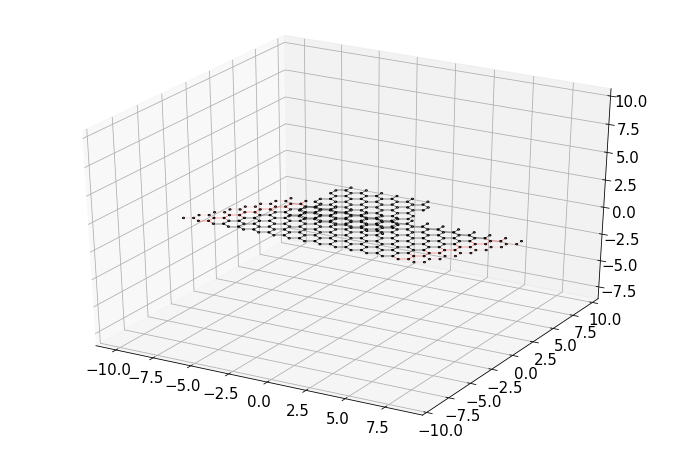

In [295]:
#### Define the leads. ####
# left lead

def lead0_shape(pos):
    x, y, z = pos
    return (np.abs(y)<W and np.abs(z)<1)

hoppingslayer1 = (((0, 0), a1, b1), ((0, 1), a1, b1), ((-1, 1), a1, b1))
sym0 = kwant.TranslationalSymmetry(bilayer.vec((-1, 0)))
lead0 = kwant.Builder(sym0)
lead0[bilayer.shape(lead0_shape, (2, 0, 0))] = 0.0
lead0[[kwant.builder.HoppingKind(*hopping) for hopping in hoppingslayer1]] = -1

# Attach the leads to the system.
sys.attach_lead(lead0)
sys.attach_lead(lead0.reversed())

# Then, plot the system with leads.
kwant.plot(sys, site_color=family_colors, site_lw=0.1, site_size=0.1, hop_lw=0.05, colorbar=False,  fig_size=(12, 8))

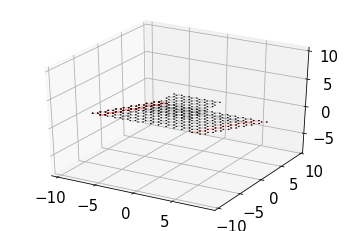

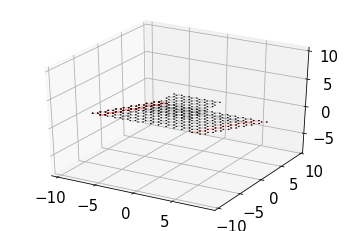